In [1]:
import sys
print("Python version:", sys.version)


Python version: 3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]


# VSN

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from category_encoders import OneHotEncoder
import seaborn as sns
import shap
import matplotlib.pyplot as plt

# Load data
data=pd.read_csv("../output/knn_vsn_aftercombat_meta.csv",index_col=0)
excluded_cols = ["Batch", "ID", "Maternal_Age", "Paternal_Age"]
data = data.drop(columns=excluded_cols)
data['Mat_Ethnicity']=data['Mat_Ethnicity'].astype('category')
data['Pat_Ethnicity']=data['Pat_Ethnicity'].astype('category')

seed = 920

name_map = pd.read_csv("../data/rename_df_reor.csv")

# Specify the target and features
target = "OBS_NORMAL_con"
features = data.drop(columns=[target])
target_data = data[target]
categorical_columns = ['Mat_Ethnicity', 'Pat_Ethnicity']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Encode categorical features
encoder = OneHotEncoder(cols=categorical_columns, use_cat_names=True)
data_encoded = encoder.fit_transform(features)


def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def compute_shap_values(model, X_train, X_test,data):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(data)
    return shap_values






ensemble_predictions = []
linear_reg_predictions = []
actuals = []

ensemble_pcc = []
ensemble_rmse = []
linear_reg_pcc = []
linear_reg_rmse = []

rkf=RepeatedKFold(n_splits=5,n_repeats=10,random_state= seed)

rkf.get_n_splits(data_encoded,target_data)

rf_shap_values_list = []
xgb_shap_values_list = []
en_shap_values_list = []
overall_shap_values_list=[]

In [13]:
np.bool = bool
np.int = int
for i,(train_index, test_index) in enumerate(rkf.split(data_encoded)):
    print(f"Fold {i}:")

    X_train, X_test = data_encoded.iloc[train_index], data_encoded.iloc[test_index]
    y_train, y_test = target_data.iloc[train_index], target_data.iloc[test_index]

    # Train models
    rf_model = RandomForestRegressor(random_state= seed)
    rf_model = train_model(rf_model, X_train, y_train)

    xgb_model = XGBRegressor(random_state= seed)
    xgb_model = train_model(xgb_model, X_train, y_train)

    en_model = ElasticNet(random_state= seed)
    en_model = train_model(en_model, X_train, y_train)

    # Ensemble prediction
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    en_pred = en_model.predict(X_test)
    
    #Second Layer stacked model
    stacked_predictions=np.column_stack((rf_pred,xgb_pred,en_pred))
    lr_meta_model=LinearRegression()
    lr_meta_model.fit(stacked_predictions,y_test)
    ensemble_pred=lr_meta_model.predict(stacked_predictions)
    
    #Obtain the coefficients for the later shapley
    coefficients=lr_meta_model.coef_
    #RF shapley values
    rf_explainer=shap.TreeExplainer(rf_model)
    rf_shap_values=rf_explainer.shap_values(data_encoded)
    #XGB shapley values
    xgb_explainer=shap.TreeExplainer(xgb_model)
    xgb_shap_values=xgb_explainer.shap_values(data_encoded)
    #EN shapley values
    en_explainer=shap.Explainer(en_model,X_train)
    en_shap_values=en_explainer(data_encoded).values
    
    #Calculated the weighted shap
    overall_shap=(coefficients[0]*rf_shap_values+
                  coefficients[1]*xgb_shap_values+
                  coefficients[2]*en_shap_values)
    rf_shap_values_list.append(coefficients[0]*rf_shap_values)
    xgb_shap_values_list.append(coefficients[1]*xgb_shap_values)
    en_shap_values_list.append(coefficients[2]*en_shap_values)
    overall_shap_values_list.append(overall_shap)
    
    # Train Linear Regression(To compare)
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    
    # Store predictions and actual values
    ensemble_predictions.append(ensemble_pred)
    linear_reg_predictions.append(lr_pred)
    actuals.append(y_test.values)

    # Calculate performance metrics
    ensemble_pcc.append(pearsonr(ensemble_pred, y_test)[0])
    ensemble_rmse.append(mean_squared_error(y_test, ensemble_pred, squared=False))  # RMSE
    linear_reg_pcc.append(pearsonr(lr_pred, y_test)[0])
    linear_reg_rmse.append(mean_squared_error(y_test, lr_pred, squared=False))  # RMSE
# Concatenate results
ensemble_predictions = np.concatenate(ensemble_predictions)
linear_reg_predictions = np.concatenate(linear_reg_predictions)
actuals = np.concatenate(actuals)

Fold 0:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 1:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 2:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 3:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 4:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 5:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 6:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 7:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 8:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 9:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 10:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 11:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 12:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 13:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 14:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 15:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 16:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 17:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 18:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 19:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 20:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 21:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 22:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 23:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 24:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 25:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 26:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 27:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 28:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 29:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 30:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 31:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 32:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 33:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 34:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 35:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 36:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 37:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 38:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 39:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 40:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 41:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 42:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 43:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 44:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 45:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 46:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 47:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 48:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Fold 49:


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [14]:
rf_shap_list=(np.array(np.abs(rf_shap_values_list)).sum(axis=(0,1)))/(50*87)
xgb_shap_list=np.array(xgb_shap_values_list).sum(axis=(0,1))/(50*87)
en_shap_list=np.array(en_shap_values_list).sum(axis=(0,1))/(50*87)

np.mean(linear_reg_pcc)

0.23755090559611922

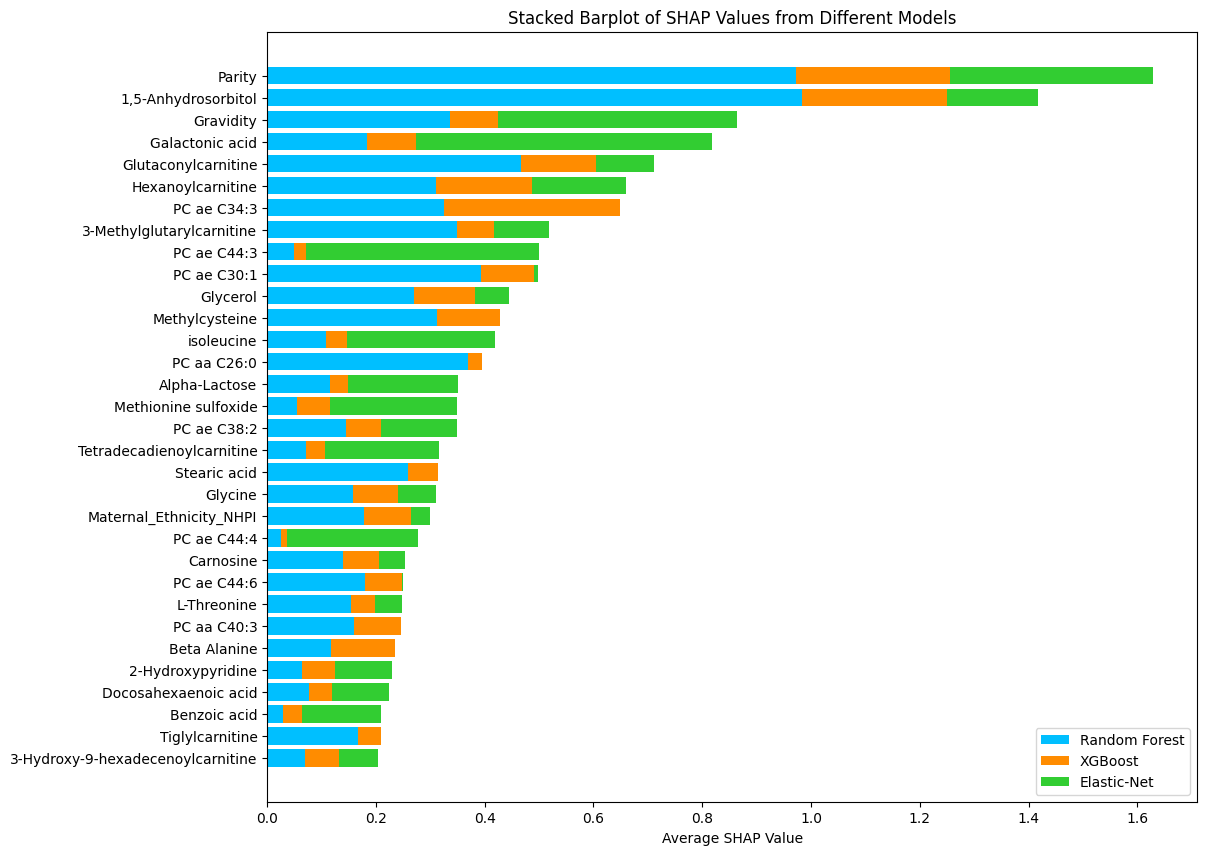

Ranked features with SHAP values saved to: /nfs/dcmb-lgarmire/boweil/ED/GWAS/pathway/ranked_features_with_shap.txt


In [20]:
# Calculate mean absolute SHAP values for each feature across all models
shap_rf_mean = np.mean(np.abs(rf_shap_values_list), axis=(0,1))
shap_xgb_mean = np.mean(np.abs(xgb_shap_values_list), axis=(0,1))
shap_en_mean = np.mean(np.abs(en_shap_values_list), axis=(0,1))

shap_combined = pd.DataFrame({
    'Feature': data_encoded.columns,
    'SHAP_RF': shap_rf_mean,
    'SHAP_XGB': shap_xgb_mean,
    'SHAP_EN': shap_en_mean
})
mapping_dict = pd.Series(name_map.lili.values, index=name_map.clean).to_dict()
shap_combined['Feature'] = shap_combined['Feature'].replace(mapping_dict)

shap_combined['Feature'] = shap_combined['Feature'].replace('Mat_Ethnicity_3.0', 'Maternal_Ethnicity_NHPI')
shap_combined['Average_SHAP'] = shap_combined[['SHAP_RF', 'SHAP_XGB', 'SHAP_EN']].mean(axis=1)

# Select the top 32 features based on average SHAP value
top_features = shap_combined.nlargest(32, 'Average_SHAP')
top_features_forcor = shap_combined.nlargest(32, 'Average_SHAP')['Feature']



clinical_prefixes = ["Batch", "ID", "Maternal_Age", "Paternal_Age",
                     "Gravidity", "Parity", "Mat_Ethnicity", "Pat_Ethnicity","Maternal_Ethnicity"]
shap_filtered = shap_combined[~shap_combined['Feature'].str.startswith(tuple(clinical_prefixes))].copy()
shap_filtered['Average_SHAP'] = shap_filtered[['SHAP_RF', 'SHAP_XGB', 'SHAP_EN']].mean(axis=1)
shap_filtered_sorted = shap_filtered.sort_values('Average_SHAP', ascending=False)
ranked_features = shap_filtered_sorted['Feature'].tolist()
output_path = "../output/index_sequence_update.txt"
with open(output_path, 'w') as f:
    for feature in ranked_features:
        f.write(f"{feature}\n")
        

top_features['SHAP_RF_Norm'] = top_features['SHAP_RF']
top_features['SHAP_XGB_Norm'] = top_features['SHAP_XGB']
top_features['SHAP_EN_Norm'] = top_features['SHAP_EN']

# Plot the stacked barplot for SHAP values
fig, ax = plt.subplots(figsize=(12, 10))

colors = ['deepskyblue', 'darkorange', 'limegreen']
labels = ['Random Forest', 'XGBoost', 'Elastic-Net']
bottom = np.zeros(len(top_features))
for i, model in enumerate(['SHAP_RF_Norm', 'SHAP_XGB_Norm', 'SHAP_EN_Norm']):
    ax.barh(top_features['Feature'], top_features[model], left=bottom, color=colors[i], label=labels[i])
    bottom += top_features[model]

ax.set_xlabel('Average SHAP Value')
ax.set_title('Stacked Barplot of SHAP Values from Different Models')
ax.legend()
plt.gca().invert_yaxis()
plt.savefig('../Figures/Fig3_SHAP.png', dpi=600, bbox_inches='tight')
plt.show()

# Calculate total SHAP values (stacked sum) for each feature
top_features['Total_SHAP'] = top_features['SHAP_RF'] + top_features['SHAP_XGB'] + top_features['SHAP_EN']

output_ranked_features = "../output/ranked_features_with_shap.txt"
with open(output_ranked_features, 'w') as f:
    for idx, row in top_features.iterrows():
        f.write(f"{row['Feature']}\t{row['Total_SHAP']:.4f}\n")



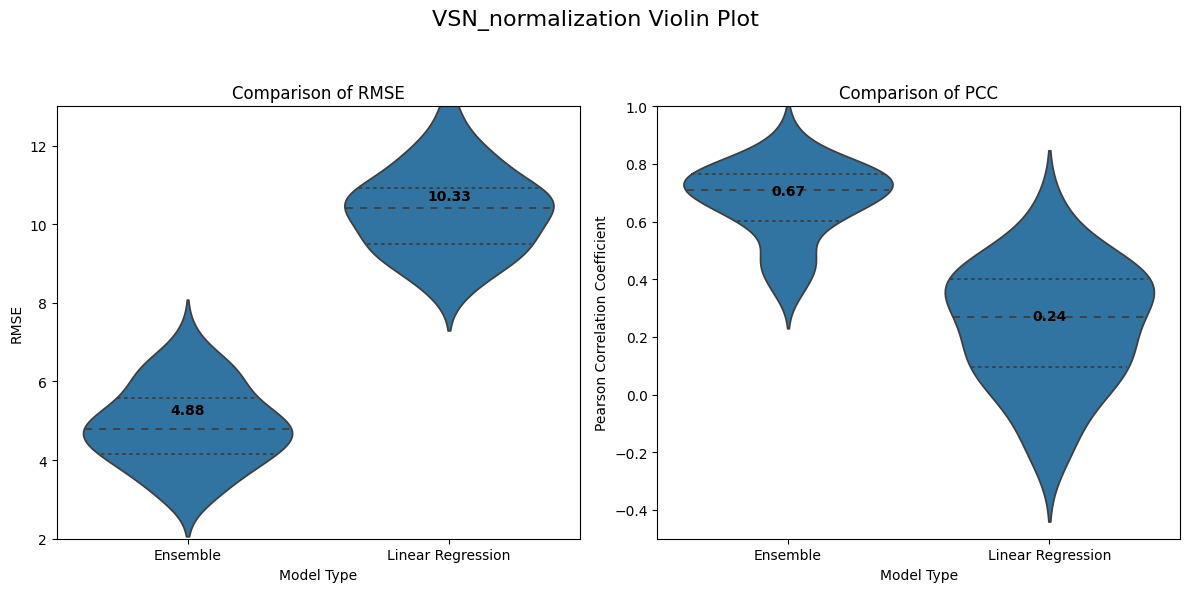

In [8]:
df_rmse = pd.DataFrame({
    'Model Type': ['Ensemble'] * len(ensemble_rmse) + ['Linear Regression'] * len(linear_reg_rmse),
    'Metric': ['RMSE'] * (len(ensemble_rmse) + len(linear_reg_rmse)),
    'Value': ensemble_rmse + linear_reg_rmse
})

df_pcc = pd.DataFrame({
    'Model Type': ['Ensemble'] * len(ensemble_pcc) + ['Linear Regression'] * len(linear_reg_pcc),
    'Metric': ['PCC'] * (len(ensemble_pcc) + len(linear_reg_pcc)),
    'Value': ensemble_pcc + linear_reg_pcc
})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax_rmse = axs[0]
sns.violinplot(x='Model Type', y='Value', hue='Metric', data=df_rmse, inner='quart', linewidth=1.3, ax=ax_rmse)
ax_rmse.set_title('Comparison of RMSE')
ax_rmse.set_xlabel('Model Type')
ax_rmse.set_ylabel('RMSE')
ax_rmse.set_ylim(2, 13)
ax_rmse.legend_.remove()

rmse_means = df_rmse.groupby('Model Type')['Value'].mean()
for i, model in enumerate(rmse_means.index):
    mean_val = rmse_means[model]
    ax_rmse.text(i, mean_val + 0.3, f"{mean_val:.2f}", ha='center', color='black', weight='bold')

ax_pcc = axs[1]
sns.violinplot(x='Model Type', y='Value', hue='Metric', data=df_pcc, inner='quart', linewidth=1.3, ax=ax_pcc)
ax_pcc.set_title('Comparison of PCC')
ax_pcc.set_xlabel('Model Type')
ax_pcc.set_ylabel('Pearson Correlation Coefficient')
ax_pcc.set_ylim(-0.5, 1)
ax_pcc.legend_.remove()

# Annotate mean values for PCC
pcc_means = df_pcc.groupby('Model Type')['Value'].mean()
for i, model in enumerate(pcc_means.index):
    mean_val = pcc_means[model]
    ax_pcc.text(i, mean_val + 0.02, f"{mean_val:.2f}", ha='center', color='black', weight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('../Figures/Fig2B_violin.png', dpi=600, bbox_inches='tight')
plt.show()
